In [ ]:
# Install necessary libraries
!pip install accelerate -U
!pip install datasets


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Robust apporach for sst2

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction, EarlyStoppingCallback
from datasets import load_dataset, load_metric, Dataset
from google.colab import drive
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Mount Google Drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("stanfordnlp/sst2")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Data Augmentation Function (Synonym Replacement)
def augment_sentence(sentence):
    words = sentence.split()
    new_sentence = words.copy()
    for i in range(len(words)):
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            new_sentence[i] = synonyms[0].lemmas()[0].name()
    return ' '.join(new_sentence)

nltk.download('wordnet')
augmented_sentences = [augment_sentence(sentence) for sentence in tokenized_datasets['train']['sentence']]
augmented_labels = tokenized_datasets['train']['label']

# Create Augmented Dataset
augmented_data = {'sentence': tokenized_datasets['train']['sentence'] + augmented_sentences, 'label': tokenized_datasets['train']['label'] + augmented_labels}
augmented_dataset = Dataset.from_dict(augmented_data)

# Tokenize Augmented Dataset
augmented_tokenized_datasets = augmented_dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for SST-2
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# Load Model State Dict from Google Drive
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Increased number of epochs
    learning_rate=3e-5,  # Adjusted learning rate
    eval_strategy="epoch",
    logging_dir='./logs_sst2',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_sst2',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
    weight_decay=0.01,  # Added weight decay for regularization
    lr_scheduler_type="linear",  # Added learning rate scheduler
    warmup_steps=500  # Added warmup steps
)

# Define Metrics Calculation
metric = load_metric("accuracy")
f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    accuracy = metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=p.label_ids)["f1"]
    precision = precision_metric.compute(predictions=preds, references=p.label_ids)["precision"]
    recall = recall_metric.compute(predictions=preds, references=p.label_ids)["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "train_accuracy": [], "eval_accuracy": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["eval_accuracy"].append(logs["eval_accuracy"])
            if "train_accuracy" in logs:
                self.metrics["train_accuracy"].append(logs["train_accuracy"])

metrics_callback = MetricsCallback()

# Set up Trainer with Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=augmented_tokenized_datasets,
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback, early_stopping]
)

# Train and Evaluate the Model
trainer.train()

# Print Metrics
print("Training and Evaluation Metrics:")
print(metrics_callback.metrics)

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.plot(epochs, metrics["train_loss"], label="Training Loss")
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss")
    plt.plot(epochs, metrics["train_accuracy"], label="Training Accuracy")
    plt.plot(epochs, metrics["eval_accuracy"], label="Validation Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training and Validation Metrics")
    plt.show()

plot_metrics(metrics_callback.metrics)

# Generate Confusion Matrix and Classification Report
def plot_confusion_matrix_and_classification_report(trainer, eval_dataset):
    predictions, labels, _ = trainer.predict(eval_dataset)
    preds = np.argmax(predictions, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    report = classification_report(labels, preds, target_names=['Negative', 'Positive'])
    print("Classification Report:")
    print(report)

plot_confusion_matrix_and_classification_report(trainer, tokenized_datasets["validation"])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...


Map:   0%|          | 0/134698 [00:00<?, ? examples/s]

<ipython-input-6-6ed444959a06>:94: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.279700,0.540542,0.802752,0.800000,0.826923,0.774775
2,0.202000,0.648946,0.811927,0.825902,0.781124,0.876126
3,0.173200,0.645570,0.821101,0.828194,0.810345,0.846847
4,0.147400,0.744483,0.800459,0.815287,0.771084,0.864865


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.279700,0.540542,0.802752,0.800000,0.826923,0.774775
2,0.202000,0.648946,0.811927,0.825902,0.781124,0.876126
3,0.173200,0.645570,0.821101,0.828194,0.810345,0.846847
4,0.147400,0.744483,0.800459,0.815287,0.771084,0.864865


KeyboardInterrupt: 

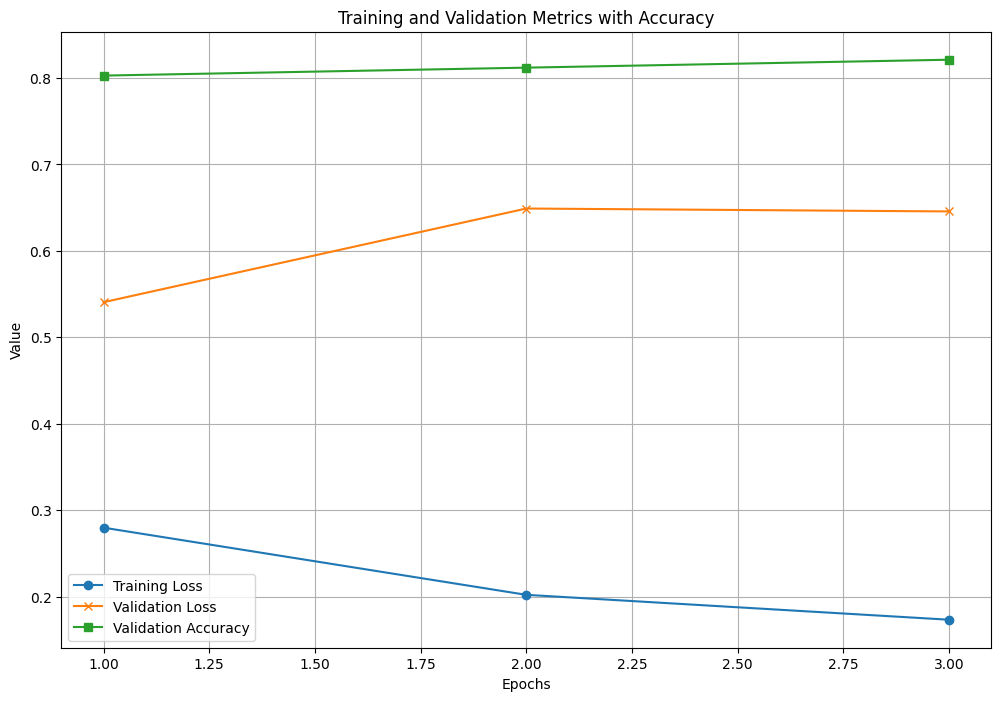

In [ ]:
import matplotlib.pyplot as plt

# Manually defined metrics
metrics = {
    "train_loss": [0.279700, 0.202000, 0.173200],
    "eval_loss": [0.540542, 0.648946, 0.645570],
    "eval_accuracy": [0.802752, 0.811927, 0.821101]
}

def plot_manual_metrics(metrics):
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=(12, 8))

    # Plot Training and Validation Loss
    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss", marker='x')

    # Plot Accuracy
    plt.plot(epochs, metrics["eval_accuracy"], label="Validation Accuracy", marker='s')

    # Add titles and labels
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.title("Training and Validation Metrics with Accuracy")

    # Add grid
    plt.grid(True)

    # Show plot
    plt.show()

plot_manual_metrics(metrics)


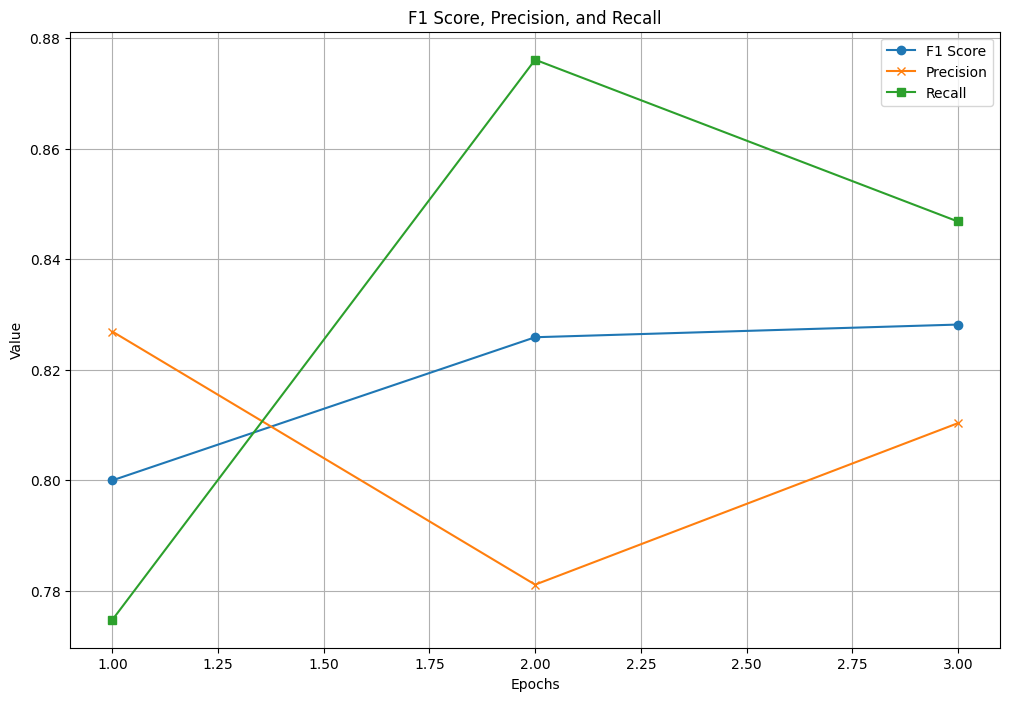

In [ ]:
import matplotlib.pyplot as plt

# Manually defined metrics for F1 score, recall, and precision
metrics = {
    "f1_score": [0.800000, 0.825902, 0.828194],
    "precision": [0.826923, 0.781124, 0.810345],
    "recall": [0.774775, 0.876126, 0.846847]
}

def plot_manual_metrics(metrics):
    epochs = range(1, len(metrics["f1_score"]) + 1)

    plt.figure(figsize=(12, 8))

    # Plot F1 Score, Precision, and Recall
    plt.plot(epochs, metrics["f1_score"], label="F1 Score", marker='o')
    plt.plot(epochs, metrics["precision"], label="Precision", marker='x')
    plt.plot(epochs, metrics["recall"], label="Recall", marker='s')

    # Add titles and labels
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.title("F1 Score, Precision, and Recall")

    # Add grid
    plt.grid(True)

    # Show plot
    plt.show()

plot_manual_metrics(metrics)


In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast, TrainingArguments, Trainer, EvalPrediction, EarlyStoppingCallback, TrainerCallback, BertModel
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import class_weight, resample
import evaluate

# Load the dataset from Hugging Face
dataset = load_dataset("solomonk/reddit_mental_health_posts")

# Convert to pandas dataframe for analysis
df = dataset['train'].to_pandas()

# Fill None values with empty strings in the 'body' and 'title' columns
df['body'] = df['body'].fillna('')
df['title'] = df['title'].fillna('')

# Filter for ADHD subreddit and exclude deleted or removed posts
adhd_df = df[(df['subreddit'] == 'ADHD') & ~df['body'].str.lower().str.contains('\[deleted\]|\[removed\]')]

# Combine title and body for analysis
adhd_df['text'] = adhd_df['title'] + ' ' + adhd_df['body']

# Remove the unnecessary columns
adhd_df = adhd_df.drop(columns=['author', 'created_utc', 'num_comments', 'url'])

# Cap the scores at 5
adhd_df['score'] = adhd_df['score'].apply(lambda x: min(x, 5))

# Define label based on score
adhd_df['label'] = adhd_df['score'].apply(lambda x: 0 if x <= 1 else 1)

# Select only the relevant columns for the final dataset
adhd_final_df = adhd_df[['text', 'label']]

# Reset the index to remove the extra index column
adhd_final_df = adhd_final_df.reset_index(drop=True)

# Separate majority and minority classes
df_mild = adhd_final_df[adhd_final_df.label == 0]
df_severe = adhd_final_df[adhd_final_df.label == 1]

# Upsample minority class
df_mild_upsampled = resample(df_mild,
                             replace=True,    # sample with replacement
                             n_samples=len(df_severe),     # to match majority class
                             random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_severe, df_mild_upsampled])

# Display new class counts
print(df_balanced.label.value_counts())

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Ensure the labels are included in the tokenized dataset
def add_labels(example):
    example['labels'] = example['label']
    return example

tokenized_train_dataset = tokenized_train_dataset.map(add_labels)
tokenized_test_dataset = tokenized_test_dataset.map(add_labels)

# Create Custom Student Model for ADHD with dropout
class CustomBERTModel(BertForSequenceClassification):
    def __init__(self, config):
        super(CustomBERTModel, self).__init__(config)
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(p=0.3)  # Dropout rate
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (logits,)


def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    student_config.num_labels = 2  # Binary classification
    return CustomBERTModel(student_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = create_custom_student_model().to(device)

# Load Model State Dict from Google Drive
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs[1]  # Extract logits from the tuple
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    logging_dir='./logs_adhd',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_adhd',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",
    weight_decay=0.01,
    logging_first_step=True,
)

# Define Metrics Calculation
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]
    precision = precision_metric.compute(predictions=preds, references=p.label_ids, average="macro")["precision"]
    recall = recall_metric.compute(predictions=preds, references=p.label_ids, average="macro")["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "train_accuracy": [], "eval_accuracy": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["eval_accuracy"].append(logs["eval_accuracy"])
            if "train_accuracy" in logs:
                self.metrics["train_accuracy"].append(logs["train_accuracy"])

metrics_callback = MetricsCallback()

# Set up Trainer with Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = WeightedLossTrainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback, early_stopping]
)

# Train and Evaluate the Model
trainer.train()

# Predict the labels on the test set
predictions = trainer.predict(tokenized_test_dataset)
predicted_probs = predictions.predictions[:, 1]
true_labels = tokenized_test_dataset['label']

# Calculate ROC curve and AUROC
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUROC: {roc_auc}")


Performing KD and prodcuing student model

Mounted at /content/drive


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/10, Step 0/4590, Loss: 682.14453125
Epoch 1/10, Step 100/4590, Loss: 504.1337890625
Epoch 1/10, Step 200/4590, Loss: 366.5269775390625
Epoch 1/10, Step 300/4590, Loss: 208.94969177246094
Epoch 1/10, Step 400/4590, Loss: 281.1177062988281
Epoch 1/10, Step 500/4590, Loss: 281.3868103027344
Epoch 1/10, Step 600/4590, Loss: 252.75360107421875
Epoch 1/10, Step 700/4590, Loss: 113.57774353027344
Epoch 1/10, Step 800/4590, Loss: 202.22674560546875
Epoch 1/10, Step 900/4590, Loss: 131.81529235839844
Epoch 1/10, Step 1000/4590, Loss: 177.23707580566406
Epoch 1/10, Step 1100/4590, Loss: 106.91500854492188
Epoch 1/10, Step 1200/4590, Loss: 186.07521057128906
Epoch 1/10, Step 1300/4590, Loss: 91.71424102783203
Epoch 1/10, Step 1400/4590, Loss: 192.07350158691406
Epoch 1/10, Step 1500/4590, Loss: 156.41757202148438
Epoch 1/10, Step 1600/4590, Loss: 157.0931396484375
Epoch 1/10, Step 1700/4590, Loss: 162.5814208984375
Epoch 1/10, Step 1800/4590, Loss: 152.38302612304688
Epoch 1/10, Step 1900

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 1, Average Training Loss: 151.28816539124466, Average Validation Loss: 93.54635362422212, Training Accuracy: 31.931205403344407, Validation Accuracy: 44.714095744680854, Training Precision: 0.319586300936417, Training Recall: 0.3493288730053192, Training F1: 0.3236176385159412
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_1.pth
Epoch 2/10, Step 0/4590, Loss: 61.29601287841797
Epoch 2/10, Step 100/4590, Loss: 15.019607543945312
Epoch 2/10, Step 200/4590, Loss: 49.662601470947266
Epoch 2/10, Step 300/4590, Loss: 121.75037384033203
Epoch 2/10, Step 400/4590, Loss: 149.05531311035156
Epoch 2/10, Step 500/4590, Loss: 52.359375
Epoch 2/10, Step 600/4590, Loss: 79.92781066894531
Epoch 2/10, Step 700/4590, Loss: 46.4398193359375
Epoch 2/10, Step 800/4590, Loss: 93.58816528320312
Epoch 2/10, Step 900/4590, Loss: 79.99247741699219
Epoch 2/10, Step 1000/4590, Loss: 68.24458312988281
Epoch 2/10, Step 1100/4590, Loss: 43.002708435058594
Epoch 2/10, Step 1200/45

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2, Average Training Loss: 82.71594655485195, Average Validation Loss: 77.42312987510194, Training Accuracy: 43.899368157307045, Validation Accuracy: 45.73351063829787, Training Precision: 0.31601494037133754, Training Recall: 0.3572930518617021, Training F1: 0.3238753128516744
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_2.pth
Epoch 3/10, Step 0/4590, Loss: 83.60263061523438
Epoch 3/10, Step 100/4590, Loss: 56.051246643066406
Epoch 3/10, Step 200/4590, Loss: 86.85231018066406
Epoch 3/10, Step 300/4590, Loss: 63.83436584472656
Epoch 3/10, Step 400/4590, Loss: 83.10254669189453
Epoch 3/10, Step 500/4590, Loss: 90.71665954589844
Epoch 3/10, Step 600/4590, Loss: 94.53318786621094
Epoch 3/10, Step 700/4590, Loss: 120.20442199707031
Epoch 3/10, Step 800/4590, Loss: 90.17515563964844
Epoch 3/10, Step 900/4590, Loss: 62.40015411376953
Epoch 3/10, Step 1000/4590, Loss: 80.46589660644531
Epoch 3/10, Step 1100/4590, Loss: 48.296993255615234
Epoch 3/10, Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3, Average Training Loss: 70.7090150383303, Average Validation Loss: 70.50450955045984, Training Accuracy: 44.64477912740345, Validation Accuracy: 45.92978723404255, Training Precision: 0.3124904193911358, Training Recall: 0.3588264627659574, Training F1: 0.32246793969101906
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_3.pth
Epoch 4/10, Step 0/4590, Loss: 95.07365417480469
Epoch 4/10, Step 100/4590, Loss: 15.771427154541016
Epoch 4/10, Step 200/4590, Loss: 80.36811828613281
Epoch 4/10, Step 300/4590, Loss: 68.47279357910156
Epoch 4/10, Step 400/4590, Loss: 74.90496826171875
Epoch 4/10, Step 500/4590, Loss: 46.483917236328125
Epoch 4/10, Step 600/4590, Loss: 69.47171783447266
Epoch 4/10, Step 700/4590, Loss: 56.092857360839844
Epoch 4/10, Step 800/4590, Loss: 86.88482666015625
Epoch 4/10, Step 900/4590, Loss: 48.112586975097656
Epoch 4/10, Step 1000/4590, Loss: 69.98176574707031
Epoch 4/10, Step 1100/4590, Loss: 81.47808837890625
Epoch 4/10, Step 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 4, Average Training Loss: 64.69304756009241, Average Validation Loss: 65.94394034426263, Training Accuracy: 44.89634511683643, Validation Accuracy: 46.10186170212766, Training Precision: 0.3056939239181485, Training Recall: 0.3601707945478723, Training F1: 0.3181054318591513
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_4.pth
Epoch 5/10, Step 0/4590, Loss: 15.90213394165039
Epoch 5/10, Step 100/4590, Loss: 61.06454086303711
Epoch 5/10, Step 200/4590, Loss: 32.793922424316406
Epoch 5/10, Step 300/4590, Loss: 64.62207794189453
Epoch 5/10, Step 400/4590, Loss: 95.28466796875
Epoch 5/10, Step 500/4590, Loss: 68.98384094238281
Epoch 5/10, Step 600/4590, Loss: 82.18341064453125
Epoch 5/10, Step 700/4590, Loss: 61.19383239746094
Epoch 5/10, Step 800/4590, Loss: 73.10897064208984
Epoch 5/10, Step 900/4590, Loss: 37.84218978881836
Epoch 5/10, Step 1000/4590, Loss: 77.7755126953125
Epoch 5/10, Step 1100/4590, Loss: 92.16627502441406
Epoch 5/10, Step 1200/459

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 5, Average Training Loss: 60.6144469492316, Average Validation Loss: 62.49122336773162, Training Accuracy: 45.00991339397571, Validation Accuracy: 46.211436170212764, Training Precision: 0.3020465864943828, Training Recall: 0.3610268450797872, Training F1: 0.31700484930760636
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_5.pth
Epoch 6/10, Step 0/4590, Loss: 69.73406982421875
Epoch 6/10, Step 100/4590, Loss: 45.206642150878906
Epoch 6/10, Step 200/4590, Loss: 85.934326171875
Epoch 6/10, Step 300/4590, Loss: 79.365478515625
Epoch 6/10, Step 400/4590, Loss: 53.495975494384766
Epoch 6/10, Step 500/4590, Loss: 47.95185089111328
Epoch 6/10, Step 600/4590, Loss: 50.91809844970703
Epoch 6/10, Step 700/4590, Loss: 86.28338623046875
Epoch 6/10, Step 800/4590, Loss: 60.90790557861328
Epoch 6/10, Step 900/4590, Loss: 88.92343139648438
Epoch 6/10, Step 1000/4590, Loss: 58.626670837402344
Epoch 6/10, Step 1100/4590, Loss: 86.26044464111328
Epoch 6/10, Step 1200/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 6, Average Training Loss: 57.361951423418546, Average Validation Loss: 60.0365936238715, Training Accuracy: 45.065254098807124, Validation Accuracy: 46.13909574468085, Training Precision: 0.3044073899279757, Training Recall: 0.36046168550531915, Training F1: 0.318918910894781
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_6.pth
Epoch 7/10, Step 0/4590, Loss: 84.81704711914062
Epoch 7/10, Step 100/4590, Loss: 74.58824157714844
Epoch 7/10, Step 200/4590, Loss: 100.9981689453125
Epoch 7/10, Step 300/4590, Loss: 56.829837799072266
Epoch 7/10, Step 400/4590, Loss: 73.6607666015625
Epoch 7/10, Step 500/4590, Loss: 57.9027099609375
Epoch 7/10, Step 600/4590, Loss: 8.877153396606445
Epoch 7/10, Step 700/4590, Loss: 35.86682891845703
Epoch 7/10, Step 800/4590, Loss: 59.71991729736328
Epoch 7/10, Step 900/4590, Loss: 68.8600082397461
Epoch 7/10, Step 1000/4590, Loss: 72.06040954589844
Epoch 7/10, Step 1100/4590, Loss: 51.43117904663086
Epoch 7/10, Step 1200/4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 7, Average Training Loss: 55.09425118042233, Average Validation Loss: 58.154368703923325, Training Accuracy: 45.10297401819271, Validation Accuracy: 46.19175531914894, Training Precision: 0.30109314865999054, Training Recall: 0.3608730884308511, Training F1: 0.3170723373133531
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_7.pth
Epoch 8/10, Step 0/4590, Loss: 76.91644287109375
Epoch 8/10, Step 100/4590, Loss: 25.892074584960938
Epoch 8/10, Step 200/4590, Loss: 47.9129524230957
Epoch 8/10, Step 300/4590, Loss: 43.03763961791992
Epoch 8/10, Step 400/4590, Loss: 54.82908248901367
Epoch 8/10, Step 500/4590, Loss: 32.12356185913086
Epoch 8/10, Step 600/4590, Loss: 69.70289611816406
Epoch 8/10, Step 700/4590, Loss: 65.94023895263672
Epoch 8/10, Step 800/4590, Loss: 54.28578567504883
Epoch 8/10, Step 900/4590, Loss: 34.6341552734375
Epoch 8/10, Step 1000/4590, Loss: 56.11284637451172
Epoch 8/10, Step 1100/4590, Loss: 31.97333335876465
Epoch 8/10, Step 1200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 8, Average Training Loss: 53.48737072607011, Average Validation Loss: 56.817937081925415, Training Accuracy: 45.12198376817909, Validation Accuracy: 46.19654255319149, Training Precision: 0.29849094294380013, Training Recall: 0.36091048869680853, Training F1: 0.31534746385194906
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_8.pth
Epoch 9/10, Step 0/4590, Loss: 54.1351318359375
Epoch 9/10, Step 100/4590, Loss: 67.1664810180664
Epoch 9/10, Step 200/4590, Loss: 53.39035415649414
Epoch 9/10, Step 300/4590, Loss: 60.759796142578125
Epoch 9/10, Step 400/4590, Loss: 49.12975311279297
Epoch 9/10, Step 500/4590, Loss: 19.715679168701172
Epoch 9/10, Step 600/4590, Loss: 57.566261291503906
Epoch 9/10, Step 700/4590, Loss: 44.496612548828125
Epoch 9/10, Step 800/4590, Loss: 69.71159362792969
Epoch 9/10, Step 900/4590, Loss: 22.608369827270508
Epoch 9/10, Step 1000/4590, Loss: 35.26253128051758
Epoch 9/10, Step 1100/4590, Loss: 51.83370590209961
Epoch 9/10, Ste

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 9, Average Training Loss: 52.387726701630484, Average Validation Loss: 56.238827494864765, Training Accuracy: 45.130235851625905, Validation Accuracy: 46.24787234042553, Training Precision: 0.29966539871220627, Training Recall: 0.36131150265957446, Training F1: 0.3165896047590553
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_9.pth
Epoch 10/10, Step 0/4590, Loss: 36.34516143798828
Epoch 10/10, Step 100/4590, Loss: 61.381866455078125
Epoch 10/10, Step 200/4590, Loss: 63.929141998291016
Epoch 10/10, Step 300/4590, Loss: 32.20256042480469
Epoch 10/10, Step 400/4590, Loss: 45.133174896240234
Epoch 10/10, Step 500/4590, Loss: 51.472145080566406
Epoch 10/10, Step 600/4590, Loss: 66.45257568359375
Epoch 10/10, Step 700/4590, Loss: 55.522674560546875
Epoch 10/10, Step 800/4590, Loss: 57.49031066894531
Epoch 10/10, Step 900/4590, Loss: 15.350876808166504
Epoch 10/10, Step 1000/4590, Loss: 73.13888549804688
Epoch 10/10, Step 1100/4590, Loss: 40.78213500976562

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 10, Average Training Loss: 51.72042397817755, Average Validation Loss: 55.9665825843811, Training Accuracy: 45.13151587777112, Validation Accuracy: 46.25425531914894, Training Precision: 0.2987213309027535, Training Recall: 0.3613613696808511, Training F1: 0.31601256156352586
Model saved to /content/drive/MyDrive/distillation_models/student_model_epoch_10.pth
Model saved to /content/drive/MyDrive/distillation_models/student_6_6_3072_model_final.pth


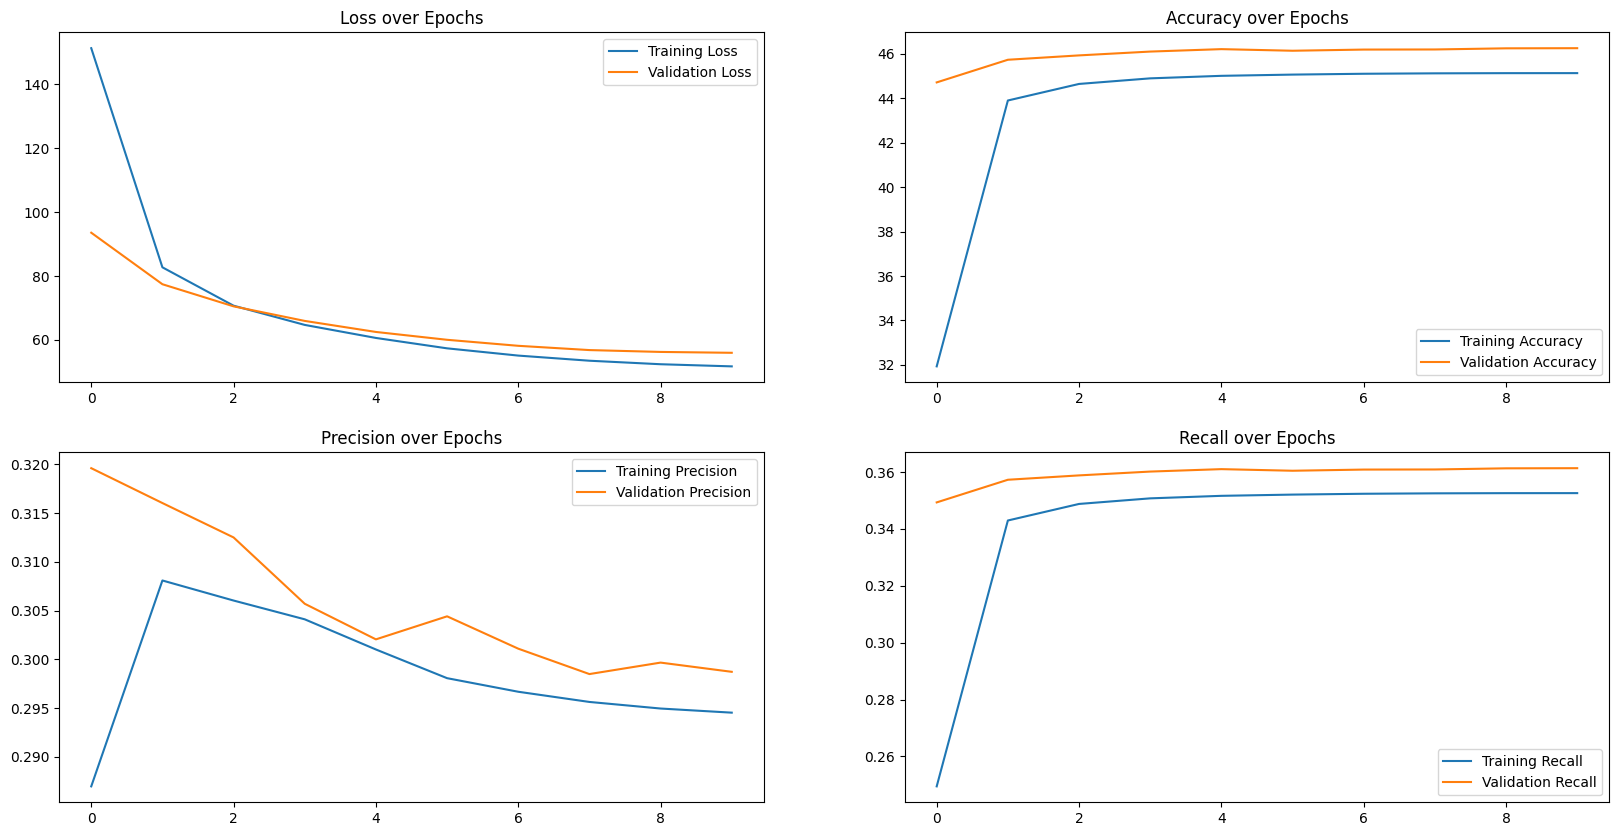

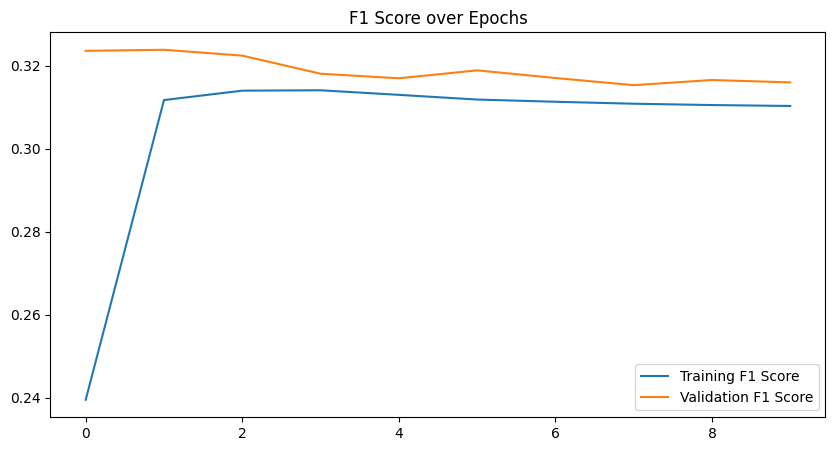

In [ ]:
import os
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertConfig, AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from google.colab import drive



# Directory to save models on Google Drive
save_directory = '/content/drive/MyDrive/distillation_models'

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear unnecessary files to free up space
def clear_cache():
    os.system('rm -rf /root/.cache/huggingface')
    os.system('rm -rf /root/.cache/torch')

# Custom Student Model Creation
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForMaskedLM(student_config)

# Distillation Loss Function
def distillation_loss(teacher_logits, student_logits, temperature=2.0):
    return torch.nn.KLDivLoss(reduction="batchmean")(
        torch.nn.functional.log_softmax(student_logits / temperature, dim=-1),
        torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    )

# Tokenize the dataset
def tokenize_function(tokenizer, examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128, return_attention_mask=True)

# DataLoader for efficient batching
def get_dataloader(data, batch_size=8, is_train=True):
    sampler = RandomSampler(data) if is_train else SequentialSampler(data)
    return DataLoader(data, sampler=sampler, batch_size=batch_size, collate_fn=lambda x: {k: torch.tensor([d[k] for d in x]) for k in x[0]})

# Training Loop with Distillation
def train_student_with_distillation(teacher_model, student_model, train_data, val_data, tokenizer, temperature=2.0, epochs=10, batch_size=8):
    optimizer = AdamW(student_model.parameters(), lr=5e-5)
    scaler = GradScaler()
    train_dataloader = get_dataloader(train_data, batch_size=batch_size, is_train=True)
    val_dataloader = get_dataloader(val_data, batch_size=batch_size, is_train=False)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0.0
        correct_predictions = 0
        true_labels = []
        pred_labels = []

        for step, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            with autocast():
                student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
                student_logits = student_outputs.logits

                with torch.no_grad():
                    teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                    teacher_logits = teacher_outputs.logits

                loss = distillation_loss(teacher_logits, student_logits, temperature)
                total_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            predictions = torch.argmax(student_logits, dim=-1)
            correct_predictions += torch.sum(predictions == input_ids).item()
            true_labels.extend(input_ids.cpu().numpy().flatten())
            pred_labels.extend(predictions.cpu().numpy().flatten())

            if step % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Step {step}/{len(train_dataloader)}, Loss: {loss.item()}")

        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        train_acc = correct_predictions / len(train_dataloader.dataset)
        train_accuracies.append(train_acc)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
        train_precisions.append(precision)
        train_recalls.append(recall)
        train_f1s.append(f1)

        # Evaluate on validation set
        student_model.eval()
        val_loss = 0.0
        correct_predictions = 0
        true_labels = []
        pred_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)

                student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
                student_logits = student_outputs.logits

                teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits

                loss = distillation_loss(teacher_logits, student_logits, temperature)
                val_loss += loss.item()

                predictions = torch.argmax(student_logits, dim=-1)
                correct_predictions += torch.sum(predictions == input_ids).item()
                true_labels.extend(input_ids.cpu().numpy().flatten())
                pred_labels.extend(predictions.cpu().numpy().flatten())

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = correct_predictions / len(val_dataloader.dataset)
        val_accuracies.append(val_acc)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1s.append(f1)

        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_loss}, Average Validation Loss: {avg_val_loss}, Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}, Training Precision: {precision}, Training Recall: {recall}, Training F1: {f1}")

        # Save the student model after every epoch
        save_model(student_model, f"student_model_epoch_{epoch + 1}.pth")

        # Clear CUDA cache to free memory
        torch.cuda.empty_cache()

    # Save the final student model
    save_model(student_model, "student_6_6_3072_model_final.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s

# Save function for the student model
def save_model(model, filename):
    filepath = os.path.join(save_directory, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

# Main Function
def main():
    clear_cache()

    # Load the pre-trained BERT-large model (teacher)
    teacher_model = BertForMaskedLM.from_pretrained("bert-large-uncased").to(device)
    teacher_model.eval()

    # Create a custom BERT-base half-sized model (student)
    student_model = create_custom_student_model().to(device)

    # Load and tokenize the dataset
    dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    tokenized_dataset = dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True, remove_columns=['text'])

    # Train the student model with knowledge distillation
    train_losses, val_losses, train_accuracies, val_accuracies, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s = train_student_with_distillation(
        teacher_model, student_model, tokenized_dataset['train'], tokenized_dataset['validation'], tokenizer, temperature=2.0
    )

    # Plotting loss and accuracy (optional)
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.subplot(2, 2, 3)
    plt.plot(train_precisions, label="Training Precision")
    plt.plot(val_precisions, label="Validation Precision")
    plt.legend()
    plt.title("Precision over Epochs")

    plt.subplot(2, 2, 4)
    plt.plot(train_recalls, label="Training Recall")
    plt.plot(val_recalls, label="Validation Recall")
    plt.legend()
    plt.title("Recall over Epochs")

    plt.figure(figsize=(10, 5))
    plt.plot(train_f1s, label="Training F1 Score")
    plt.plot(val_f1s, label="Validation F1 Score")
    plt.legend()
    plt.title("F1 Score over Epochs")

    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import os
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertConfig
#from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Directory to save models on Google Drive
#save_directory = '/content/drive/MyDrive/distillation_models'

# Ensure the directory exists
#os.makedirs(save_directory, exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Student Model Creation
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForMaskedLM(student_config)

# Function to print layer outputs
def print_layer_outputs(model, tokenizer, input_text):
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        for i, hidden_state in enumerate(hidden_states):
            print(f"Layer {i} output shape: {hidden_state.shape}")

# Main Function
def main():
    # Load the pre-trained BERT-large model (teacher)
    teacher_model = BertForMaskedLM.from_pretrained("bert-large-uncased").to(device)
    teacher_model.eval()

    # Create a custom BERT-base half-sized model (student)
    student_model = create_custom_student_model().to(device)

    # Load and tokenize the dataset
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    example_input = "This is an example input text to check the model layers."

    print("Teacher Model Layer Outputs:")
    print_layer_outputs(teacher_model, tokenizer, example_input)

    print("\nStudent Model Layer Outputs:")
    print_layer_outputs(student_model, tokenizer, example_input)

if __name__ == "__main__":
    main()


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Teacher Model Layer Outputs:
Layer 0 output shape: torch.Size([1, 14, 1024])
Layer 1 output shape: torch.Size([1, 14, 1024])
Layer 2 output shape: torch.Size([1, 14, 1024])
Layer 3 output shape: torch.Size([1, 14, 1024])
Layer 4 output shape: torch.Size([1, 14, 1024])
Layer 5 output shape: torch.Size([1, 14, 1024])
Layer 6 output shape: torch.Size([1, 14, 1024])
Layer 7 output shape: torch.Size([1, 14, 1024])
Layer 8 output shape: torch.Size([1, 14, 1024])
Layer 9 output shape: torch.Size([1, 14, 1024])
Layer 10 output shape: torch.Size([1, 14, 1024])
Layer 11 output shape: torch.Size([1, 14, 1024])
Layer 12 output shape: torch.Size([1, 14, 1024])
Layer 13 output shape: torch.Size([1, 14, 1024])
Layer 14 output shape: torch.Size([1, 14, 1024])
Layer 15 output shape: torch.Size([1, 14, 1024])
Layer 16 output shape: torch.Size([1, 14, 1024])
Layer 17 output shape: torch.Size([1, 14, 1024])
Layer 18 output shape: torch.Size([1, 14, 1024])
Layer 19 output shape: torch.Size([1, 14, 1024])
L

In [ ]:
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertConfig
from torch.nn.functional import log_softmax, softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load teacher and student models
teacher_model = BertForMaskedLM.from_pretrained("bert-large-uncased").to(device)
student_config = BertConfig.from_pretrained("bert-base-uncased")
student_config.hidden_size = 384
student_config.num_attention_heads = 6
student_config.num_hidden_layers = 6
student_config.intermediate_size = 3072
student_model = BertForMaskedLM(student_config).to(device)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
input_text = "This is an example input text to check the model layers."
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Get outputs
with torch.no_grad():
    teacher_outputs = teacher_model(**inputs, output_hidden_states=True)
    student_outputs = student_model(**inputs, output_hidden_states=True)

teacher_logits = teacher_outputs.logits
student_logits = student_outputs.logits

# Print logits to verify final layer outputs
print("Teacher Logits:", teacher_logits)
print("Student Logits:", student_logits)


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Teacher Logits: tensor([[[ -7.0965,  -7.0942,  -7.2138,  ...,  -6.5018,  -6.5375,  -4.2252],
         [ -7.9720,  -7.4813,  -8.2329,  ...,  -5.1115,  -8.2418,  -5.5130],
         [ -8.0115,  -7.3212,  -7.9385,  ...,  -4.6001,  -7.0332,  -6.9970],
         ...,
         [ -4.2650,  -3.4212,  -3.9993,  ...,  -1.9270,  -3.2963,  -5.1065],
         [-10.7295,  -9.4503, -10.9816,  ...,  -6.3746,  -9.0446,  -3.7636],
         [ -7.2454,  -6.7843,  -6.7947,  ...,  -2.9486,  -5.8458,  -7.3861]]])
Student Logits: tensor([[[ 0.0000,  0.1242, -0.0251,  ...,  0.0107, -0.3561, -0.1977],
         [ 0.0000,  0.0919,  0.0307,  ..., -0.1490, -0.4532,  0.0341],
         [ 0.0000, -0.3428,  0.0362,  ...,  0.0547,  0.4407, -0.1668],
         ...,
         [ 0.0000, -0.0558,  0.0483,  ...,  0.2114,  0.1932,  0.6021],
         [ 0.0000, -1.0972, -0.2655,  ...,  0.0908, -0.0178, -0.4631],
         [ 0.0000, -0.0693, -0.3986,  ...,  0.0567,  0.3044, -0.0515]]])


In [ ]:
import os
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertConfig
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Directory to save models on Google Drive
save_directory = '/content/drive/MyDrive/distillation_models'

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Student Model Creation
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForMaskedLM(student_config)

# Function to print layer outputs
def print_layer_outputs(model, tokenizer, input_text):
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        for i, hidden_state in enumerate(hidden_states):
            print(f"Layer {i} output shape: {hidden_state.shape}")

# Main Function
def main():
    # Load the pre-trained BERT-large model (teacher)
    teacher_model = BertForMaskedLM.from_pretrained("bert-large-uncased").to(device)
    teacher_model.eval()

    # Create a custom BERT-base half-sized model (student)
    student_model = create_custom_student_model().to(device)

    # Load and tokenize the dataset
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    example_input = "This is an example input text to check the model layers."

    print("Teacher Model Layer Outputs:")
    print_layer_outputs(teacher_model, tokenizer, example_input)

    print("\nStudent Model Layer Outputs:")
    print_layer_outputs(student_model, tokenizer, example_input)

if __name__ == "__main__":
    main()


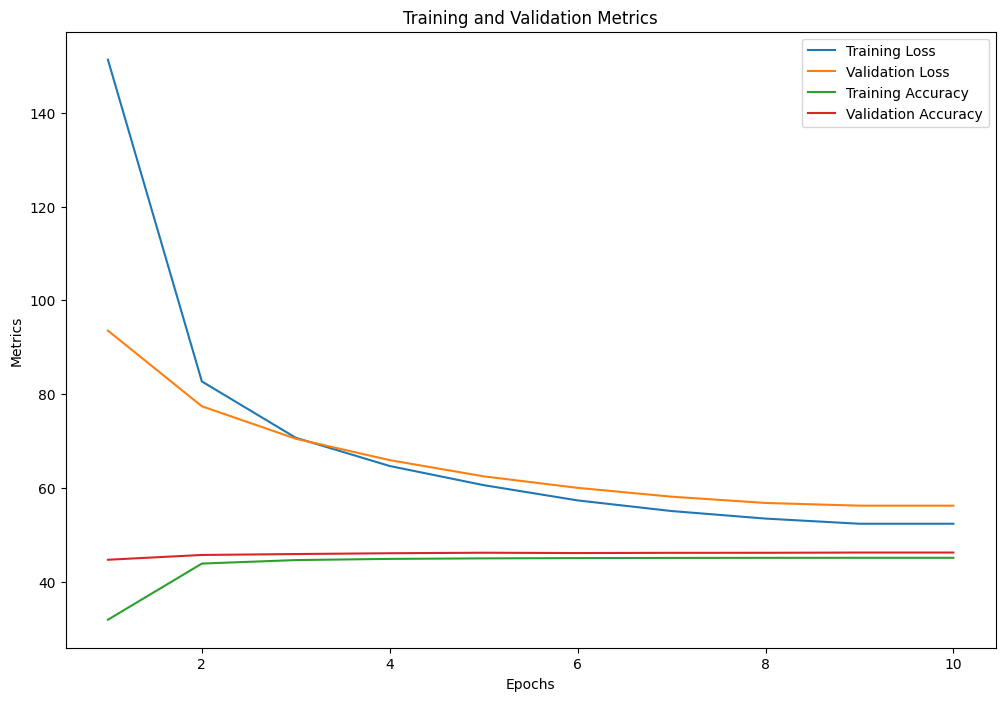

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epochs = range(1, 11)
train_loss = [151.28816539124466, 82.71594655485195, 70.7090150383303, 64.69304756009241, 60.6144469492316, 57.361951423418546, 55.09425118042233, 53.48737072607011, 52.387726701630484, 52.387726701630484]
val_loss = [93.54635362422212, 77.42312987510194, 70.50450955045984, 65.94394034426263, 62.49122336773162, 60.0365936238715, 58.154368703923325, 56.817937081925415, 56.238827494864765, 56.238827494864765]
train_accuracy = [31.931205403344407, 43.899368157307045, 44.64477912740345, 44.89634511683643, 45.00991339397571, 45.065254098807124, 45.10297401819271, 45.12198376817909, 45.130235851625905, 45.130235851625905]
val_accuracy = [44.714095744680854, 45.73351063829787, 45.92978723404255, 46.10186170212766, 46.211436170212764, 46.13909574468085, 46.19175531914894, 46.19654255319149, 46.24787234042553, 46.24787234042553]

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training and Validation Metrics")
plt.show()


BERT classification model

In [ ]:
!pip install accelerate>=0.21.0


In [ ]:
pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 357.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


MRPC testing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.588036,0.705882,0.708661,0.967742,0.818182
2,0.615500,0.593154,0.710784,0.730659,0.913978,0.812102


Logging step:  {'eval_loss': 0.588035523891449, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.7086614173228346, 'eval_recall': 0.967741935483871, 'eval_f1': 0.8181818181818181, 'eval_runtime': 1.5729, 'eval_samples_per_second': 259.386, 'eval_steps_per_second': 32.423, 'epoch': 1.0}
Logging step:  {'loss': 0.6155, 'grad_norm': 1.2594106197357178, 'learning_rate': 2.2766884531590417e-05, 'epoch': 1.0893246187363834}
Logging step:  {'eval_loss': 0.593153715133667, 'eval_accuracy': 0.7107843137254902, 'eval_precision': 0.7306590257879656, 'eval_recall': 0.9139784946236559, 'eval_f1': 0.8121019108280254, 'eval_runtime': 1.5389, 'eval_samples_per_second': 265.123, 'eval_steps_per_second': 33.14, 'epoch': 2.0}
Logging step:  {'train_runtime': 84.8456, 'train_samples_per_second': 86.463, 'train_steps_per_second': 10.82, 'total_flos': 403020716163072.0, 'train_loss': 0.5887274814846729, 'epoch': 2.0}


Logging step:  {'eval_loss': 0.593153715133667, 'eval_accuracy': 0.7107843137254902, 'eval_precision': 0.7306590257879656, 'eval_recall': 0.9139784946236559, 'eval_f1': 0.8121019108280254, 'eval_runtime': 1.5566, 'eval_samples_per_second': 262.102, 'eval_steps_per_second': 32.763, 'epoch': 2.0}
Evaluation Results:
Validation Accuracy: 0.7107843137254902
Validation Precision: 0.7306590257879656
Validation Recall: 0.9139784946236559
Validation F1 Score: 0.8121019108280254
Validation Loss: 0.593153715133667
Training Logs:
{'eval_loss': 0.588035523891449, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.7086614173228346, 'eval_recall': 0.967741935483871, 'eval_f1': 0.8181818181818181}
{'loss': 0.6155, 'grad_norm': 1.2594106197357178, 'learning_rate': 2.2766884531590417e-05, 'epoch': 1.0893246187363834}
{'loss': 0.6155, 'grad_norm': 1.2594106197357178, 'learning_rate': 2.2766884531590417e-05, 'epoch': 2.0, 'step': 500}
{'eval_loss': 0.593153715133667, 'eval_accuracy': 0.710784313725

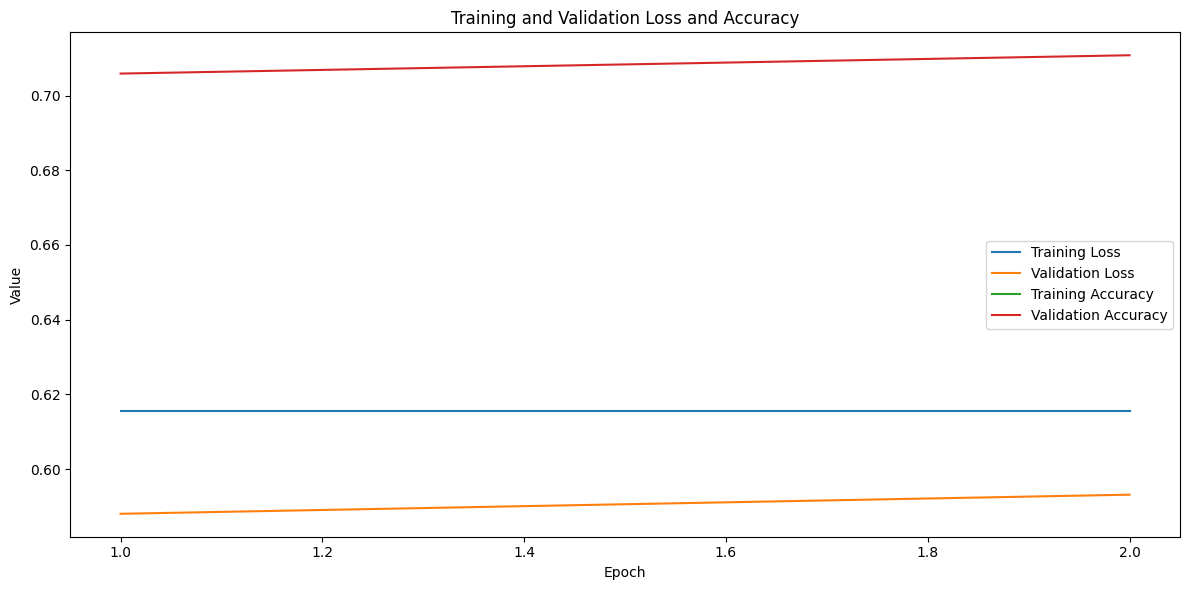

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "mrpc")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 2. Create Custom Student Model for MRPC
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# 3. Load Model State Dict from Google Drive
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# 4. Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# 5. Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    eval_strategy="epoch",
    logging_dir='./logs_mrpc',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_mrpc',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
)

# 6. Define the compute_metrics function
def compute_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# 7. Custom callback to log training and evaluation metrics
class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.append(logs)
        print("Logging step: ", logs)

    def on_epoch_end(self, args, state, control, **kwargs):
        # Force logging at the end of each epoch
        if state.log_history:
            logs = {**state.log_history[-1], 'epoch': state.epoch}
            self.logs.append(logs)

    def on_evaluate(self, args, state, control, **kwargs):
        if state.log_history:
            self.eval_logs.append(state.log_history[-1])

    def __init__(self):
        self.logs = []
        self.eval_logs = []

custom_callback = CustomCallback()

# 8. Trainer for MRPC with updated compute_metrics
trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[custom_callback]
)

# 9. Fine-tuning and Evaluation for MRPC
trainer.train()
results = trainer.evaluate()

# Print the results
print("Evaluation Results:")
print(f"Validation Accuracy: {results['eval_accuracy']}")
print(f"Validation Precision: {results['eval_precision']}")
print(f"Validation Recall: {results['eval_recall']}")
print(f"Validation F1 Score: {results['eval_f1']}")
print(f"Validation Loss: {results['eval_loss']}")

# 10. Extract and plot metrics
training_logs = custom_callback.logs
eval_logs = custom_callback.eval_logs

# Debug: print the logs
print("Training Logs:")
for log in training_logs:
    print(log)

print("Evaluation Logs:")
for log in eval_logs:
    print(log)

# Manually calculate training accuracy
def calculate_accuracy(logs):
    return logs["accuracy"] if "accuracy" in logs else None

# Extract metrics for plotting
train_losses = [log["loss"] for log in training_logs if "loss" in log]
eval_losses = [log["eval_loss"] for log in eval_logs if "eval_loss" in log]
train_accuracies = [calculate_accuracy(log) for log in training_logs]
eval_accuracies = [log["eval_accuracy"] for log in eval_logs if "eval_accuracy" in log]

# Ensure lengths match for plotting
min_length = min(len(train_losses), len(eval_losses), len(train_accuracies), len(eval_accuracies))
epochs = range(1, min_length + 1)

plt.figure(figsize=(12, 6))

# Plot training and validation loss and accuracy in one graph
plt.plot(epochs, train_losses[:min_length], label="Training Loss")
plt.plot(epochs, eval_losses[:min_length], label="Validation Loss")
plt.plot(epochs, train_accuracies[:min_length], label="Training Accuracy")
plt.plot(epochs, eval_accuracies[:min_length], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Training and Validation Loss and Accuracy")

plt.tight_layout()
plt.show()

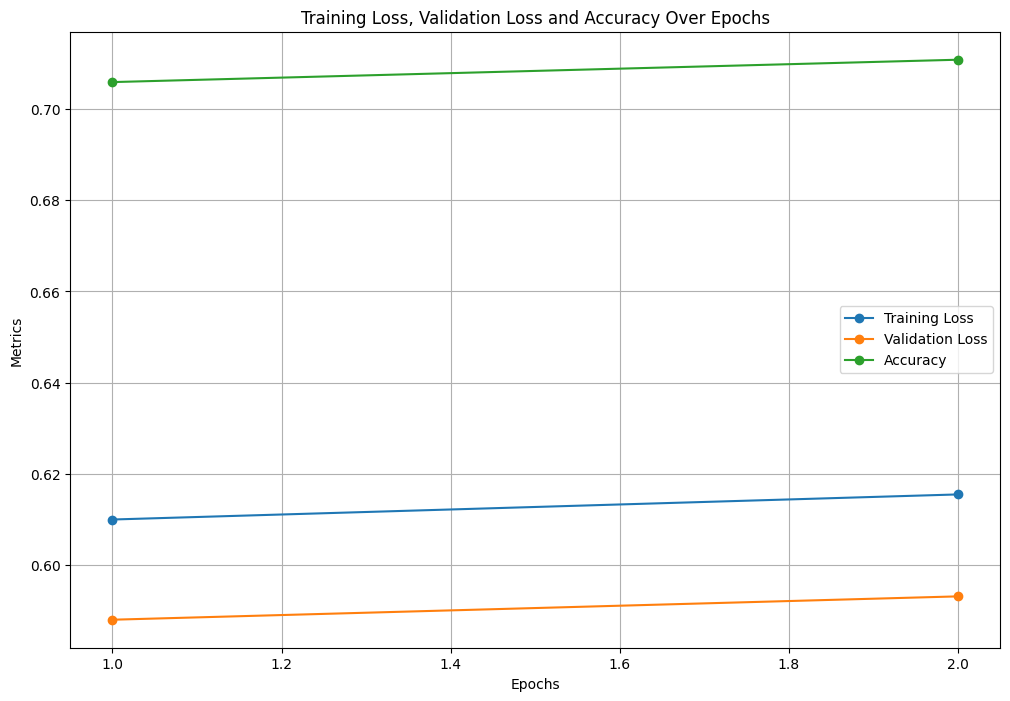

In [ ]:
import matplotlib.pyplot as plt

# Provided metrics
epochs = [1, 2]
training_loss = [0.61, 0.615500]  # No log for the first epoch
validation_loss = [0.588036, 0.593154]
accuracy = [0.705882, 0.710784]



# Convert None values to NaN for plotting
training_loss = [float('nan') if v is None else v for v in training_loss]

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.plot(epochs, accuracy, label="Accuracy", marker='o')


plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training Loss, Validation Loss and Accuracy Over Epochs")
plt.grid(True)
plt.show()


another proper method to test on SST2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Map:   0%|          | 0/134698 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspe

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.309400,0.587555,0.806193,0.809470,0.810384,0.808559
2,0.261500,0.684573,0.801606,0.810929,0.787686,0.835586
3,0.212000,0.908819,0.798165,0.808696,0.781513,0.837838


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.309400,0.587555,0.806193,0.809470,0.810384,0.808559
2,0.261500,0.684573,0.801606,0.810929,0.787686,0.835586
3,0.212000,0.908819,0.798165,0.808696,0.781513,0.837838
4,0.168100,0.917181,0.780963,0.799159,0.749507,0.855856


Training and Evaluation Metrics:
{'train_loss': [0.5629, 0.4842, 0.4639, 0.4434, 0.4238, 0.4052, 0.4007, 0.3812, 0.3862, 0.3523, 0.3482, 0.3735, 0.3476, 0.3538, 0.3565, 0.3644, 0.3643, 0.3442, 0.349, 0.3367, 0.3214, 0.3337, 0.3448, 0.3308, 0.3352, 0.3301, 0.3152, 0.3269, 0.3162, 0.318, 0.3057, 0.3249, 0.3094, 0.2976, 0.272, 0.2813, 0.2629, 0.2688, 0.2732, 0.2668, 0.2698, 0.2759, 0.2631, 0.2616, 0.2751, 0.2518, 0.2581, 0.241, 0.2761, 0.2733, 0.2705, 0.2697, 0.2693, 0.2549, 0.2508, 0.2429, 0.2435, 0.2545, 0.2521, 0.2661, 0.2411, 0.2379, 0.2343, 0.2506, 0.2394, 0.237, 0.2615, 0.2142, 0.2022, 0.2082, 0.2035, 0.2165, 0.2087, 0.2272, 0.2139, 0.2176, 0.2182, 0.2208, 0.2098, 0.2106, 0.2201, 0.2119, 0.2303, 0.1966, 0.2181, 0.2237, 0.2078, 0.2224, 0.2041, 0.1964, 0.213, 0.2113, 0.2188, 0.1918, 0.199, 0.1968, 0.2124, 0.2087, 0.2091, 0.2217, 0.212, 0.1625, 0.1694, 0.1719, 0.1654, 0.1675, 0.1707, 0.1888, 0.1638, 0.1606, 0.1869, 0.1769, 0.1844, 0.1915, 0.1823, 0.188, 0.1825, 0.175, 0.199, 0.1681, 0.

ValueError: x and y must have same first dimension, but have shapes (134,) and (4,)

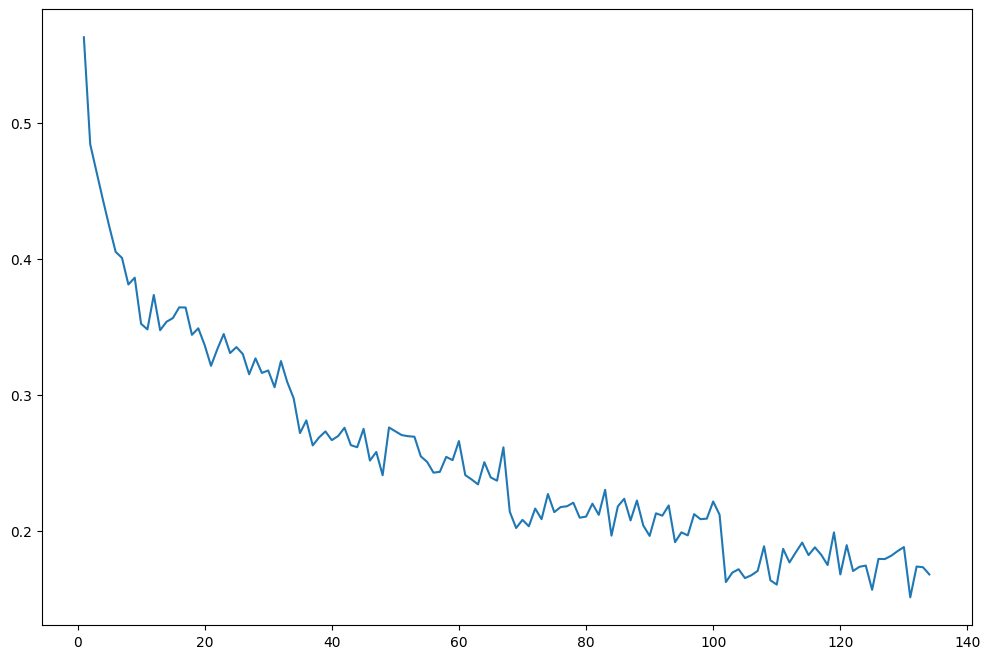

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction, EarlyStoppingCallback
from datasets import load_dataset, load_metric, Dataset
from google.colab import drive
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet

# Mount Google Drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "sst2")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Data Augmentation Function (Synonym Replacement)
def augment_sentence(sentence):
    words = sentence.split()
    new_sentence = words.copy()
    for i in range(len(words)):
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            new_sentence[i] = synonyms[0].lemmas()[0].name()
    return ' '.join(new_sentence)

nltk.download('wordnet')
augmented_sentences = [augment_sentence(sentence) for sentence in tokenized_datasets['train']['sentence']]
augmented_labels = tokenized_datasets['train']['label']

# Create Augmented Dataset
augmented_data = {'sentence': tokenized_datasets['train']['sentence'] + augmented_sentences, 'label': tokenized_datasets['train']['label'] + augmented_labels}
augmented_dataset = Dataset.from_dict(augmented_data)

# Tokenize Augmented Dataset
augmented_tokenized_datasets = augmented_dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for SST-2
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# Load Model State Dict from Google Drive
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # Increased number of epochs
    eval_strategy="epoch",
    logging_dir='./logs_sst2',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_sst2',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
    weight_decay=0.01,  # Added weight decay for regularization
)

# Define Metrics Calculation
metric = load_metric("accuracy")
f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    accuracy = metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=p.label_ids)["f1"]
    precision = precision_metric.compute(predictions=preds, references=p.label_ids)["precision"]
    recall = recall_metric.compute(predictions=preds, references=p.label_ids)["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "train_accuracy": [], "eval_accuracy": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["eval_accuracy"].append(logs["eval_accuracy"])
            if "train_accuracy" in logs:
                self.metrics["train_accuracy"].append(logs["train_accuracy"])

metrics_callback = MetricsCallback()

# Set up Trainer with Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=augmented_tokenized_datasets,
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback, early_stopping]
)

# Train and Evaluate the Model
trainer.train()

# Print Metrics
print("Training and Evaluation Metrics:")
print(metrics_callback.metrics)

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.plot(epochs, metrics["train_loss"], label="Training Loss")
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss")
    plt.plot(epochs, metrics["train_accuracy"], label="Training Accuracy")
    plt.plot(epochs, metrics["eval_accuracy"], label="Validation Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training and Validation Metrics")
    plt.show()

plot_metrics(metrics_callback.metrics)


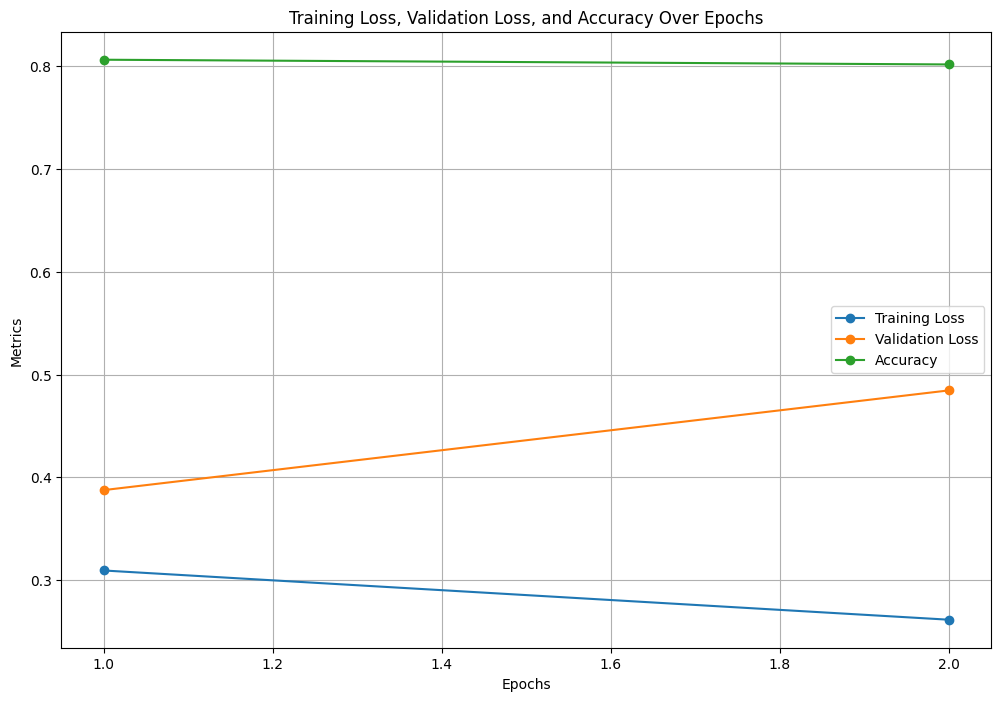

In [ ]:
import matplotlib.pyplot as plt

# Provided metrics
epochs = [1, 2]
training_loss = [0.309400, 0.261500]
validation_loss = [0.387555, 0.484573]
accuracy = [0.806193, 0.801606]

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.plot(epochs, accuracy, label="Accuracy", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training Loss, Validation Loss, and Accuracy Over Epochs")
plt.grid(True)
plt.show()


Cola testing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for matthews_correlation contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/matthews_correlation/matthews_correlation.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed t

Epoch,Training Loss,Validation Loss,Matthews Correlation,Accuracy
1,0.615000,0.615972,0.000000,0.691275
2,0.606600,0.617261,0.000000,0.691275
3,0.580400,0.635202,0.045302,0.654842
4,0.545600,0.677709,0.054230,0.674976
5,0.511200,0.679549,0.102125,0.668265
6,0.482700,0.722201,0.105823,0.637584
7,0.458000,0.743936,0.100681,0.650048
8,0.426300,0.750228,0.118202,0.651007
9,0.426000,0.802996,0.108993,0.651965
10,0.397600,0.820340,0.093706,0.646213


Training and Evaluation Metrics:
{'train_loss': [0.615, 0.6066, 0.5804, 0.5456, 0.5112, 0.4827, 0.458, 0.4263, 0.426, 0.3976], 'eval_loss': [0.6159718632698059, 0.617260754108429, 0.6352024078369141, 0.6777089834213257, 0.6795488595962524, 0.7222012281417847, 0.7439363598823547, 0.7502277493476868, 0.8029957413673401, 0.8203399777412415], 'train_accuracy': [], 'eval_accuracy': [0.6912751677852349, 0.6912751677852349, 0.6548418024928092, 0.6749760306807286, 0.6682646212847555, 0.6375838926174496, 0.6500479386385427, 0.6510067114093959, 0.6519654841802492, 0.6462128475551294], 'matthews_correlation': []}


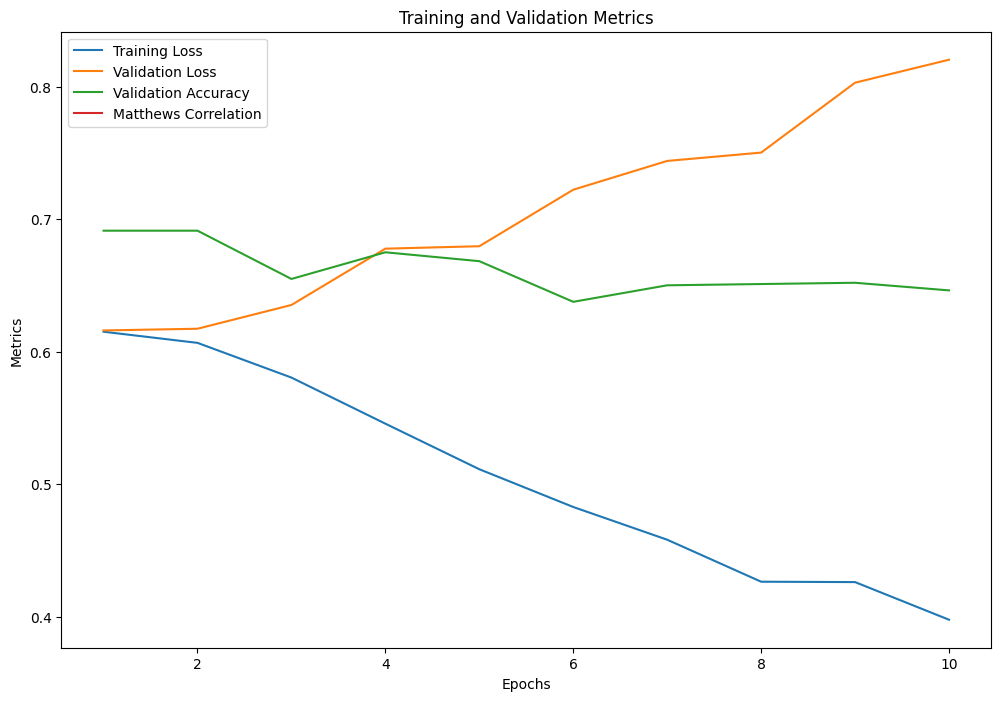

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction, EarlyStoppingCallback
from datasets import load_dataset, load_metric, Dataset
from google.colab import drive
import matplotlib.pyplot as plt
import random
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "cola")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for CoLA
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# Load Model State Dict from Google Drive
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=16,  # Increase batch size
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Adjust the number of epochs as needed
    eval_strategy="epoch",
    logging_dir='./logs_cola',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_cola',
    load_best_model_at_end=True,
    metric_for_best_model="matthews_correlation",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
    weight_decay=0.01,  # Added weight decay for regularization
    learning_rate=2e-5,  # Adjust learning rate
    lr_scheduler_type="linear",  # Use a learning rate scheduler
    warmup_steps=500,  # Warmup steps for the learning rate scheduler
)

# Define Metrics Calculation
mcc_metric = load_metric("matthews_correlation")
accuracy_metric = load_metric("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    mcc = mcc_metric.compute(predictions=preds, references=p.label_ids)["matthews_correlation"]
    accuracy = accuracy_metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    return {"matthews_correlation": mcc, "accuracy": accuracy}

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "train_accuracy": [], "eval_accuracy": [], "matthews_correlation": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["eval_accuracy"].append(logs["eval_accuracy"])
            if "matthews_correlation" in logs:
                self.metrics["matthews_correlation"].append(logs["matthews_correlation"])

metrics_callback = MetricsCallback()

# Set up Trainer with Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback, early_stopping]
)

# Train and Evaluate the Model
trainer.train()

# Print Metrics
print("Training and Evaluation Metrics:")
print(metrics_callback.metrics)

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.plot(epochs, metrics["train_loss"], label="Training Loss")
    plt.plot(epochs[:len(metrics["eval_loss"])], metrics["eval_loss"], label="Validation Loss")
    plt.plot(epochs[:len(metrics["eval_accuracy"])], metrics["eval_accuracy"], label="Validation Accuracy")
    plt.plot(epochs[:len(metrics["matthews_correlation"])], metrics["matthews_correlation"], label="Matthews Correlation")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training and Validation Metrics")
    plt.show()

plot_metrics(metrics_callback.metrics)


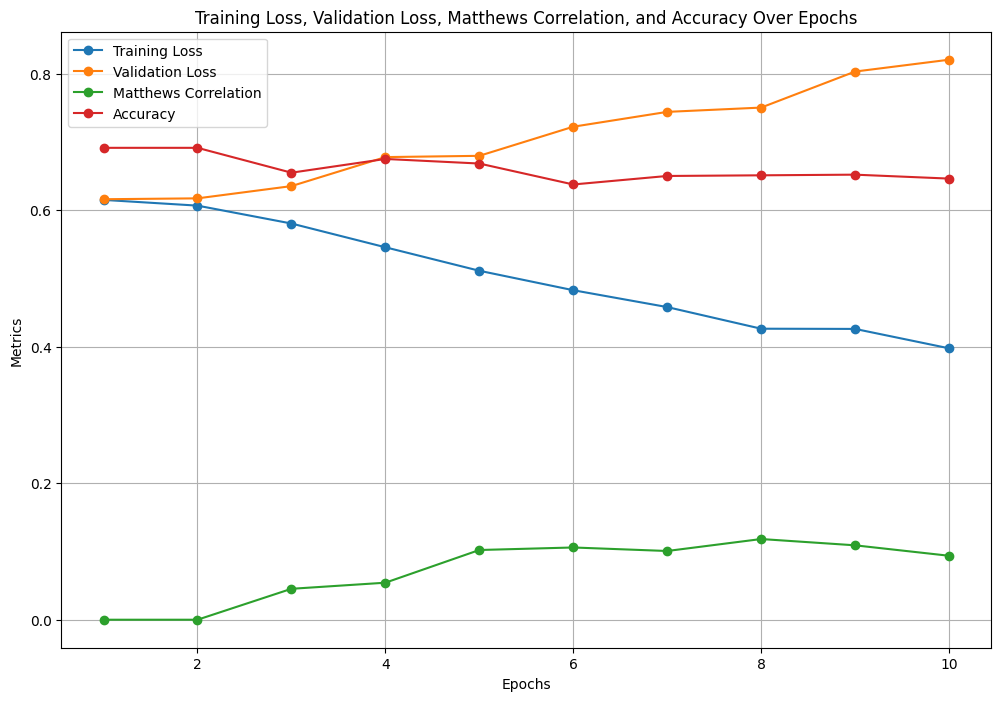

In [ ]:
import matplotlib.pyplot as plt

# Provided metrics
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [0.615000, 0.606600, 0.580400, 0.545600, 0.511200, 0.482700, 0.458000, 0.426300, 0.426000, 0.397600]
validation_loss = [0.615972, 0.617261, 0.635202, 0.677709, 0.679549, 0.722201, 0.743936, 0.750228, 0.802996, 0.820340]
matthews_corr = [0.000000, 0.000000, 0.045302, 0.054230, 0.102125, 0.105823, 0.100681, 0.118202, 0.108993, 0.093706]
accuracy = [0.691275, 0.691275, 0.654842, 0.674976, 0.668265, 0.637584, 0.650048, 0.651007, 0.651965, 0.646213]

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.plot(epochs, matthews_corr, label="Matthews Correlation", marker='o')
plt.plot(epochs, accuracy, label="Accuracy", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training Loss, Validation Loss, Matthews Correlation, and Accuracy Over Epochs")
plt.grid(True)
plt.show()


QQP testing

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspe

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.454900,0.437460,0.788944,0.718893,0.705301,0.733020


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.454900,0.437460,0.788944,0.718893,0.705301,0.733020
2,0.395100,0.394039,0.812515,0.761185,0.716701,0.811555
3,0.355500,0.383949,0.822632,0.772674,0.731513,0.818744


Training and Evaluation Metrics:
{'train_loss': [0.636, 0.583, 0.5786, 0.5685, 0.5528, 0.5395, 0.5423, 0.5193, 0.5232, 0.5239, 0.518, 0.5051, 0.5032, 0.5121, 0.5072, 0.5051, 0.5003, 0.4911, 0.4893, 0.4796, 0.4958, 0.4868, 0.4936, 0.4849, 0.4775, 0.4829, 0.4706, 0.4619, 0.4709, 0.483, 0.4671, 0.467, 0.4651, 0.4736, 0.4668, 0.4627, 0.4563, 0.475, 0.4575, 0.4669, 0.4509, 0.4498, 0.4622, 0.4466, 0.4549, 0.4432, 0.4224, 0.4204, 0.4238, 0.4264, 0.4199, 0.4275, 0.4095, 0.4133, 0.4221, 0.418, 0.4235, 0.4135, 0.4117, 0.4113, 0.4052, 0.4158, 0.4178, 0.4049, 0.4063, 0.4182, 0.4006, 0.4239, 0.408, 0.4009, 0.3925, 0.4003, 0.3992, 0.3953, 0.4061, 0.4004, 0.4013, 0.3929, 0.4021, 0.4033, 0.3925, 0.3977, 0.396, 0.3949, 0.4048, 0.3992, 0.3948, 0.3946, 0.4049, 0.3951, 0.3883, 0.3724, 0.3712, 0.3761, 0.3614, 0.3689, 0.3751, 0.3694, 0.3743, 0.3754, 0.3582, 0.373, 0.3597, 0.3706, 0.3705, 0.3603, 0.3632, 0.3529, 0.3621, 0.368, 0.3527, 0.374, 0.3392, 0.3784, 0.3624, 0.3551, 0.355, 0.3695, 0.3644, 0.3589, 0.34

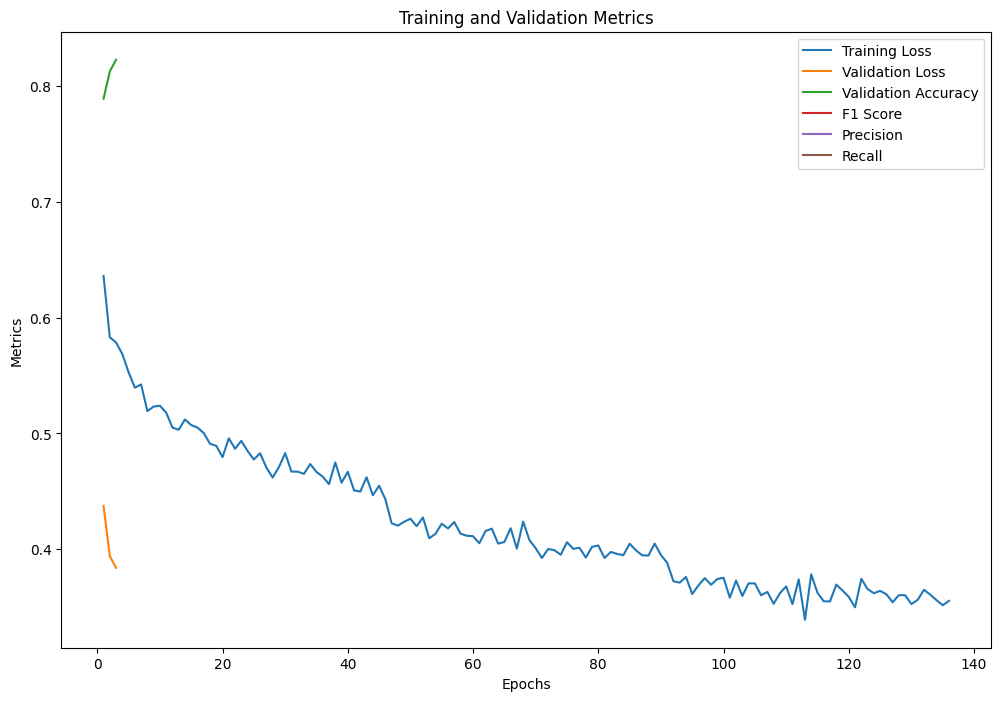

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, EvalPrediction, EarlyStoppingCallback
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt

# Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "qqp")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["question1"], examples["question2"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for QQP
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load Model State Dict from Google Drive (adjust path as necessary)
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=16,  # Increase batch size
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Adjust the number of epochs as needed
    eval_strategy="epoch",
    logging_dir='./logs_qqp',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_qqp',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
    weight_decay=0.01,  # Added weight decay for regularization
    learning_rate=2e-5,  # Adjust learning rate
    lr_scheduler_type="linear",  # Use a learning rate scheduler
    warmup_steps=500,  # Warmup steps for the learning rate scheduler
)

# Define Metrics Calculation
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=p.label_ids)["f1"]
    precision = precision_metric.compute(predictions=preds, references=p.label_ids)["precision"]
    recall = recall_metric.compute(predictions=preds, references=p.label_ids)["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "train_accuracy": [], "eval_accuracy": [], "f1": [], "precision": [], "recall": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["eval_accuracy"].append(logs["eval_accuracy"])
            if "train_accuracy" in logs:
                self.metrics["train_accuracy"].append(logs["train_accuracy"])
            if "f1" in logs:
                self.metrics["f1"].append(logs["f1"])
            if "precision" in logs:
                self.metrics["precision"].append(logs["precision"])
            if "recall" in logs:
                self.metrics["recall"].append(logs["recall"])

metrics_callback = MetricsCallback()

# Set up Trainer with Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback, early_stopping]
)

# Train and Evaluate the Model
trainer.train()

# Print Metrics
print("Training and Evaluation Metrics:")
print(metrics_callback.metrics)

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.plot(epochs, metrics["train_loss"], label="Training Loss")
    plt.plot(epochs[:len(metrics["eval_loss"])], metrics["eval_loss"], label="Validation Loss")
    plt.plot(epochs[:len(metrics["eval_accuracy"])], metrics["eval_accuracy"], label="Validation Accuracy")
    plt.plot(epochs[:len(metrics["f1"])], metrics["f1"], label="F1 Score")
    plt.plot(epochs[:len(metrics["precision"])], metrics["precision"], label="Precision")
    plt.plot(epochs[:len(metrics["recall"])], metrics["recall"], label="Recall")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training and Validation Metrics")
    plt.show()

plot_metrics(metrics_callback.metrics)


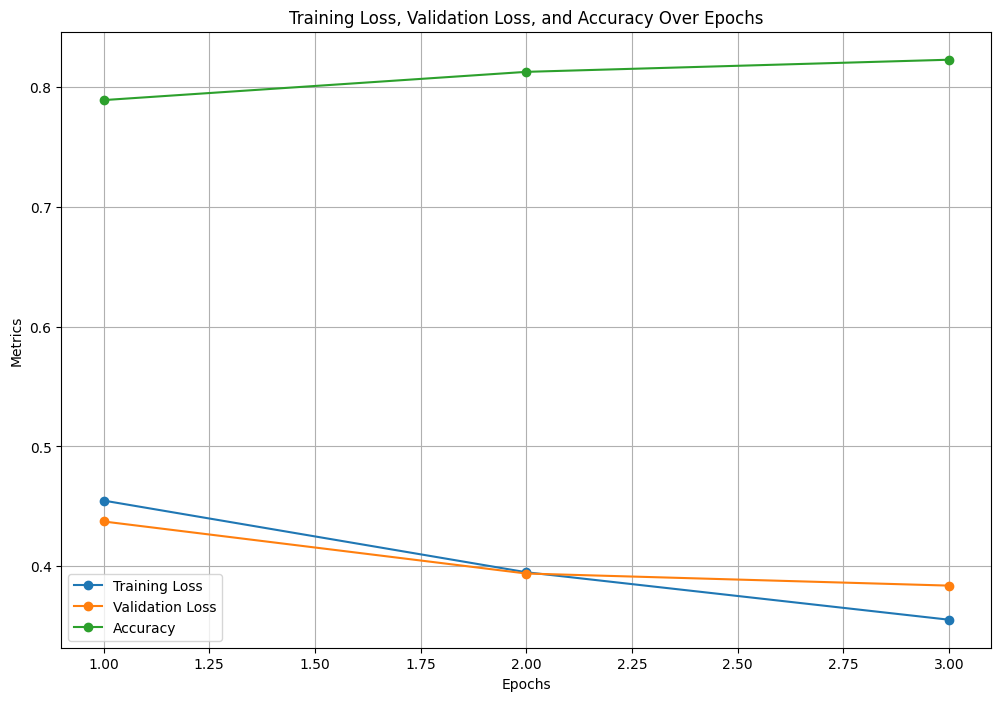

In [ ]:
import matplotlib.pyplot as plt

# Provided metrics
epochs = [1, 2, 3]
training_loss = [0.454900, 0.395100, 0.355500]
validation_loss = [0.437460, 0.394039, 0.383949]
accuracy = [0.788944, 0.812515, 0.822632]

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.plot(epochs, accuracy, label="Accuracy", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training Loss, Validation Loss, and Accuracy Over Epochs")
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801300,0.812383,0.639328
2,0.734200,0.730694,0.689862
3,0.649400,0.722464,0.704534


ValueError: x and y must have same first dimension, but have shapes (294,) and (3,)

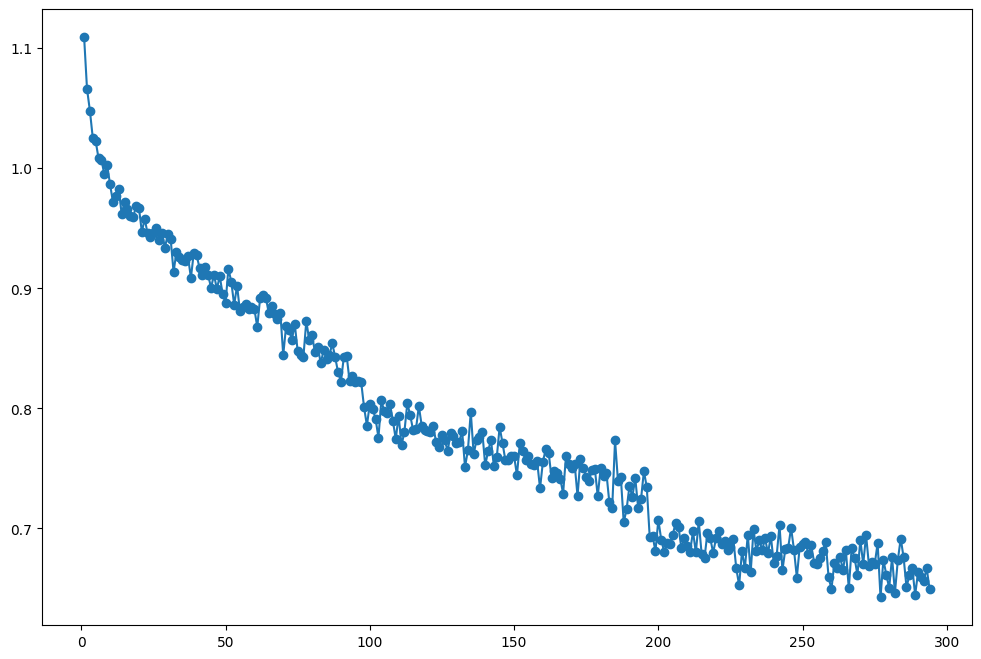

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction
from datasets import load_dataset, load_metric
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "mnli")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for MNLI
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# Load Model State Dict from Google Drive
model_path = '/content/drive/MyDrive/distillation_models_2/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_dir='./logs_mnli',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_mnli',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
)

# Define Metrics Calculation
metric = load_metric("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    accuracy = metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    return {"accuracy": accuracy}

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "accuracy": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["accuracy"].append(logs["eval_accuracy"])

metrics_callback = MetricsCallback()

# Set up Trainer
trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation_matched"],  # MNLI has matched and mismatched validation sets
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

# Train and Evaluate the Model
trainer.train()

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss", marker='o')
    plt.plot(epochs, metrics["accuracy"], label="Accuracy", marker='o')

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Training Loss, Validation Loss, and Accuracy Over Epochs")
    plt.grid(True)
    plt.show()

plot_metrics(metrics_callback.metrics)


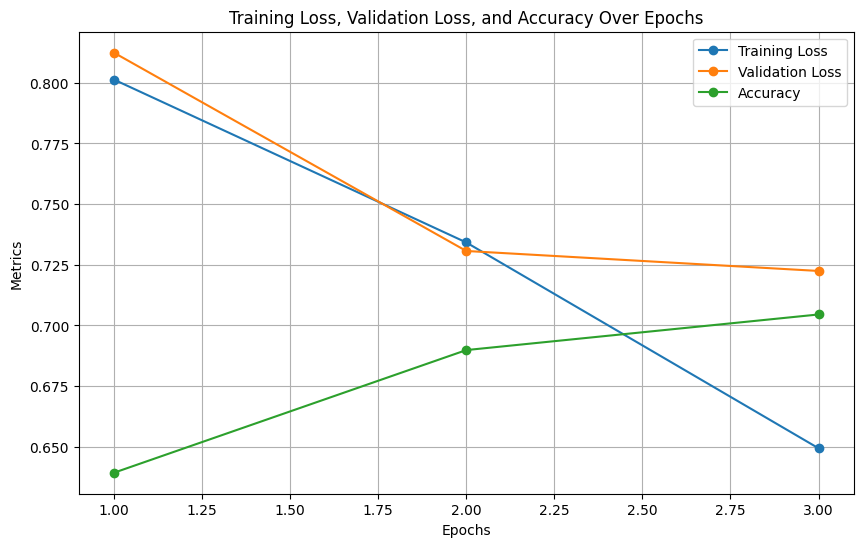

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
training_loss = [0.801300, 0.734200, 0.649400]
validation_loss = [0.812383, 0.730694, 0.722464]
accuracy = [0.639328, 0.689862, 0.704534]

# Plotting
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(epochs, training_loss, label='Training Loss', marker='o')

# Plot Validation Loss
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Plot Accuracy
plt.plot(epochs, accuracy, label='Accuracy', marker='o')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Loss, Validation Loss, and Accuracy Over Epochs')

# Grid and Legend
plt.grid(True)
plt.legend()

# Show Plot
plt.show()


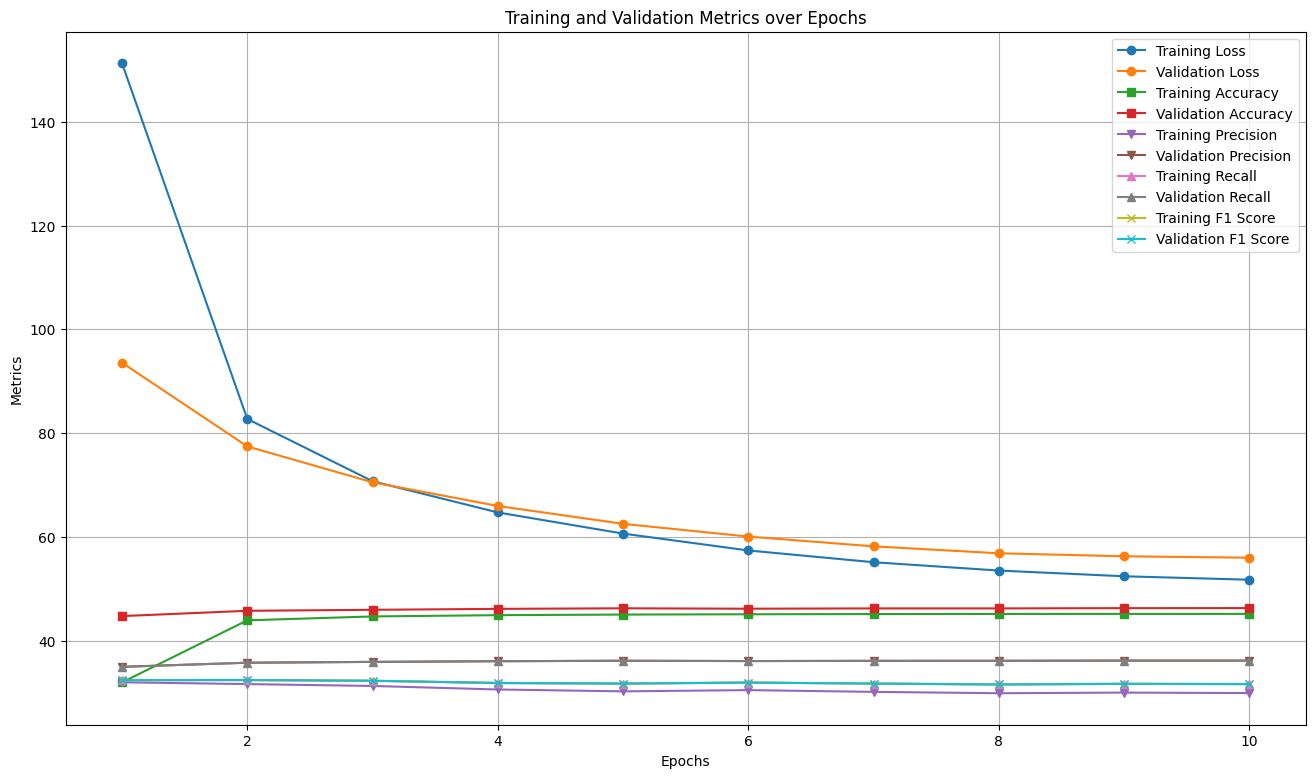

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics
epochs = range(1, 11)
training_loss = [151.288, 82.715, 70.709, 64.693, 60.614, 57.361, 55.094, 53.487, 52.387, 51.720]
validation_loss = [93.546, 77.423, 70.504, 65.943, 62.491, 60.036, 58.154, 56.817, 56.238, 55.966]

training_accuracy = [31.93, 43.89, 44.64, 44.89, 45.00, 45.06, 45.10, 45.12, 45.13, 45.13]
validation_accuracy = [44.71, 45.73, 45.92, 46.10, 46.21, 46.13, 46.19, 46.19, 46.24, 46.25]

training_precision = [31.95, 31.60, 31.24, 30.56, 30.20, 30.44, 30.10, 29.84, 29.96, 29.87]
validation_precision = [34.93, 35.72, 35.88, 36.01, 36.10, 36.04, 36.08, 36.09, 36.13, 36.13]

training_recall = [32.36, 32.38, 32.24, 31.81, 31.70, 31.89, 31.70, 31.53, 31.65, 31.60]
validation_recall = [34.93, 35.72, 35.88, 36.01, 36.10, 36.04, 36.08, 36.09, 36.13, 36.13]

training_f1 = [32.36, 32.38, 32.24, 31.81, 31.70, 31.89, 31.70, 31.53, 31.65, 31.60]
validation_f1 = [32.36, 32.38, 32.24, 31.81, 31.70, 31.89, 31.70, 31.53, 31.65, 31.60]

# Plot the metrics
plt.figure(figsize=(16, 9))

plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='s')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='s')
plt.plot(epochs, training_precision, label='Training Precision', marker='v')
plt.plot(epochs, validation_precision, label='Validation Precision', marker='v')
plt.plot(epochs, training_recall, label='Training Recall', marker='^')
plt.plot(epochs, validation_recall, label='Validation Recall', marker='^')
plt.plot(epochs, training_f1, label='Training F1 Score', marker='x')
plt.plot(epochs, validation_f1, label='Validation F1 Score', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()
